# Kronfluence Tutorial

Kronfluence is a repository designed to compute influence functions using Kronecker-factored Approximate Curvature (KFAC) or Eigenvalue-corrected KFAC (EKFAC). In this short tutorial, we will introduce some functionalities of Kronfluence on the UCI regression pipeline (it is quick to run and does not require GPUs).

In [1]:
import math
import random
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from random import shuffle
from torch import nn
from torch.utils import data
from tueplots import cycler, markers
from tueplots.constants import markers as marker_constants
from tueplots.constants.color import palettes
from tqdm import tqdm

from examples.uci.pipeline import construct_regression_mlp, get_regression_dataset

plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(markers.with_edge())

## Setting up the Model and Dataset

Before computing influence scores, we need to prepare the trained model and datasets. Let's define the hyperparameters that we will use to train the model.

In [2]:
dataset_name = "concrete"
dataset_dir = "./data"
train_batch_size = 32
eval_batch_size = 128
num_train_epochs = 40
learning_rate = 0.03
weight_decay = 1e-05

After loading training and query (validation) datasets, we will train the model.

In [3]:
train_dataset = get_regression_dataset(data_name=dataset_name, split="train", dataset_dir=dataset_dir)
query_dataset = get_regression_dataset(data_name=dataset_name, split="valid", dataset_dir=dataset_dir)
train_dataset.data_x.shape, train_dataset.data_y.shape

((927, 8), (927, 1))

In [4]:
construct_regression_mlp()

Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
)

In [5]:
def train(
    dataset: data.Dataset,
    batch_size: int,
    num_train_epochs: int,
    learning_rate: float,
    weight_decay: float,
    disable_tqdm: bool = False,
) -> nn.Module:
    train_dataloader = data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    model = construct_regression_mlp()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    for epoch in range(num_train_epochs):
        total_loss = 0.0
        with tqdm(train_dataloader, unit="batch", disable=disable_tqdm) as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                model.zero_grad()
                inputs, targets = batch
                outputs = model(inputs)
                loss = F.mse_loss(outputs, targets)
                total_loss += loss.detach().float()
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=total_loss.item() / len(train_dataloader))
    return model

In [6]:
model = train(
    dataset=train_dataset,
    batch_size=train_batch_size,
    num_train_epochs=num_train_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
)

Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 644.60batch/s, loss=0.08]


We can compute the loss on the query dataset after training the model.

In [7]:
def evaluate(model: nn.Module, dataset: data.Dataset, batch_size: int) -> float:
    dataloader = data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
    )

    model.eval()
    total_loss = 0.0
    for batch in dataloader:
        with torch.no_grad():
            inputs, targets = batch
            outputs = model(inputs)
            loss = F.mse_loss(outputs, targets, reduction="sum")
            total_loss += loss.detach().float()

    return total_loss.item() / len(dataloader.dataset)

evaluate(model=model, dataset=query_dataset, batch_size=eval_batch_size)

0.14787048043556583

## Defining a Task

Before computing influence scores, we need to define a `Task` class. This class encapsulates information about the trained model and how influence scores will be computed: (1) how to compute the training loss; (2) how to compute the measurement; (3) which modules to use for influence function computations; and (4) whether the model used attention mask.

In [8]:
from kronfluence.analyzer import Analyzer, prepare_model
from kronfluence.task import Task

We can optionally use `Analyzer.get_module_summary` to easily get the name of available modules.

In [9]:
print(Analyzer.get_module_summary(model))

==Model Summary==
Module Name: `0`, Module: Linear(in_features=8, out_features=128, bias=True)
Module Name: `2`, Module: Linear(in_features=128, out_features=128, bias=True)
Module Name: `4`, Module: Linear(in_features=128, out_features=128, bias=True)
Module Name: `6`, Module: Linear(in_features=128, out_features=1, bias=True)


In [10]:
class RegressionTask(Task):
    def compute_train_loss(
        self,
        batch: Tuple[torch.Tensor, torch.Tensor],
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        inputs, targets = batch
        outputs = model(inputs)
        if not sample:
            return F.mse_loss(outputs, targets, reduction="sum")
        # Sample the outputs from the model's prediction for true Fisher.
        with torch.no_grad():
            sampled_targets = torch.normal(outputs, std=math.sqrt(0.5))
        return F.mse_loss(outputs, sampled_targets.detach(), reduction="sum")

    def compute_measurement(
        self,
        batch: Tuple[torch.Tensor, torch.Tensor],
        model: nn.Module,
    ) -> torch.Tensor:
        # The measurement function is set as a training loss.
        return self.compute_train_loss(batch, model, sample=False)

    def tracked_modules(self) -> Optional[List[str]]:
        # These are the module names we will use to compute influence functions.
        return ["0", "2", "4", "6"]

Kronfluence wraps all supported modules within the model with `TrackedModule`. This wrapper will be used for computing the factors and influence scores. Once your model is ready and the task is defined, prepare your model with:

In [11]:
task = RegressionTask()
model = prepare_model(model, task)

You can see that the `TrackedModule` are now installed.

In [12]:
model

Sequential(
  (0): TrackedLinear(
    (original_module): Linear(in_features=8, out_features=128, bias=True)
  )
  (1): ReLU()
  (2): TrackedLinear(
    (original_module): Linear(in_features=128, out_features=128, bias=True)
  )
  (3): ReLU()
  (4): TrackedLinear(
    (original_module): Linear(in_features=128, out_features=128, bias=True)
  )
  (5): ReLU()
  (6): TrackedLinear(
    (original_module): Linear(in_features=128, out_features=1, bias=True)
  )
)

We can now create the `Analyzer` instance to compute influence scores. The `analysis_name` is used to organize the results.

In [13]:
analyzer = Analyzer(
    analysis_name="tutorial",
    model=model,
    task=task,
    cpu=True,
)

## Computing Influence Factors

We can compute the activation and pseudo-activation covariance matrices with `fit_covariance_matrices`.

In [14]:
analyzer.fit_covariance_matrices(
    factors_name="tutorial_factor",
    dataset=train_dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)

Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]


You can load the computed covariance matrix with `load_covariance_matrices`.

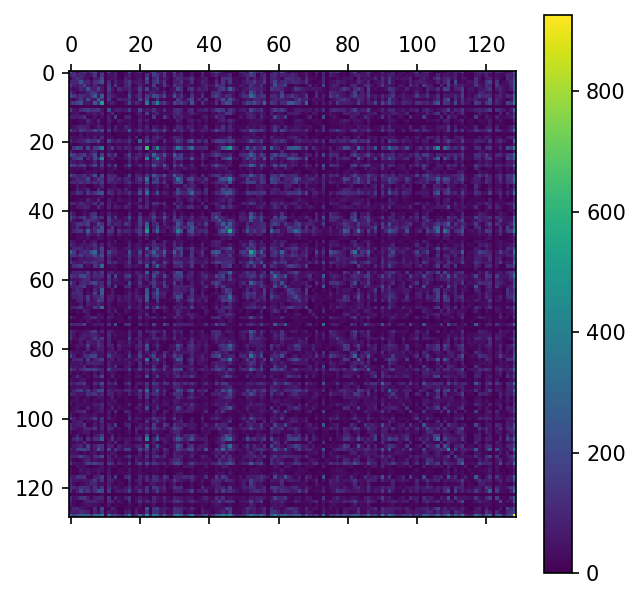

In [15]:
covariance_factors = analyzer.load_covariance_matrices(factors_name="tutorial_factor")
plt.matshow(covariance_factors["activation_covariance"]["2"])
plt.colorbar()

We can perform Eigendecomposition after fitting covariance matrices.

In [16]:
analyzer.perform_eigendecomposition(
    factors_name="tutorial_factor",
    overwrite_output_dir=True,
)

Performing Eigendecomposition [4/4] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]


Next, we can fit the Lambda (corrected-eigenvalues for EKFAC) matrices with:

In [17]:
analyzer.fit_lambda_matrices(
    factors_name="tutorial_factor",
    dataset=train_dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)

Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]


While we sequentially called `fit_covariance_matrices`, `perform_eigendecomposition`, and `fit_lambda_matrices` in the above example, we can instead fit all required factors with:

In [18]:
analyzer.fit_all_factors(
    factors_name="tutorial_factor",
    dataset=train_dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)

Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Performing Eigendecomposition [4/4] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]


## Computing Influence Scores

After computing all neccessary factors, we now compute the pairwise influence scores.

In [19]:
analyzer.compute_pairwise_scores(
    scores_name="tutorial_score",
    factors_name="tutorial_factor",
    query_dataset=query_dataset,
    train_dataset=train_dataset,
    per_device_query_batch_size=len(query_dataset),
    overwrite_output_dir=True,
)

Computing pairwise scores (query gradient) [0/1]   0%|                                                                                                       [time left: ?, time spent: 00:00]
Computing pairwise scores (training gradient) [1/1] 100%|███████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Computing pairwise scores (query gradient) [1/1] 100%|██████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Computing pairwise scores (query gradient) [0/1]   0%|                                                                                                       [time left: ?, time spent: 00:00]
Computing pairwise scores (training gradient) [1/1] 100%|███████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Computing pairwise scores (query gradient) [1

You can load the pairwise scores with `load_pairwise_scores`. The pairwise score will have the dimension `query_dataset_size x train_dataset_size`.

In [20]:
scores = analyzer.load_pairwise_scores(scores_name="tutorial_score")
scores["all_modules"].shape

torch.Size([103, 927])

If you would like to obtain the influence score for each module, you can pass in `ScoreArguments` to `compute_pairwise_scores`.

In [21]:
from kronfluence import ScoreArguments

score_args = ScoreArguments(per_module_score=True)
analyzer.compute_pairwise_scores(
    score_args=score_args,
    scores_name="tutorial_per_module_score",
    factors_name="tutorial_factor",
    query_dataset=query_dataset,
    train_dataset=train_dataset,
    per_device_query_batch_size=len(query_dataset),
    overwrite_output_dir=True,
)

Computing pairwise scores (query gradient) [0/1]   0%|                                                                                                       [time left: ?, time spent: 00:00]
Computing pairwise scores (training gradient) [1/1] 100%|███████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Computing pairwise scores (query gradient) [1/1] 100%|██████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Computing pairwise scores (query gradient) [0/1]   0%|                                                                                                       [time left: ?, time spent: 00:00]
Computing pairwise scores (training gradient) [1/1] 100%|███████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Computing pairwise scores (query gradient) [1

In [22]:
per_module_scores = analyzer.load_pairwise_scores(scores_name="tutorial_per_module_score")
per_module_scores.keys()

dict_keys(['0', '2', '4', '6'])

We can also visualize the score matrix for the last module.

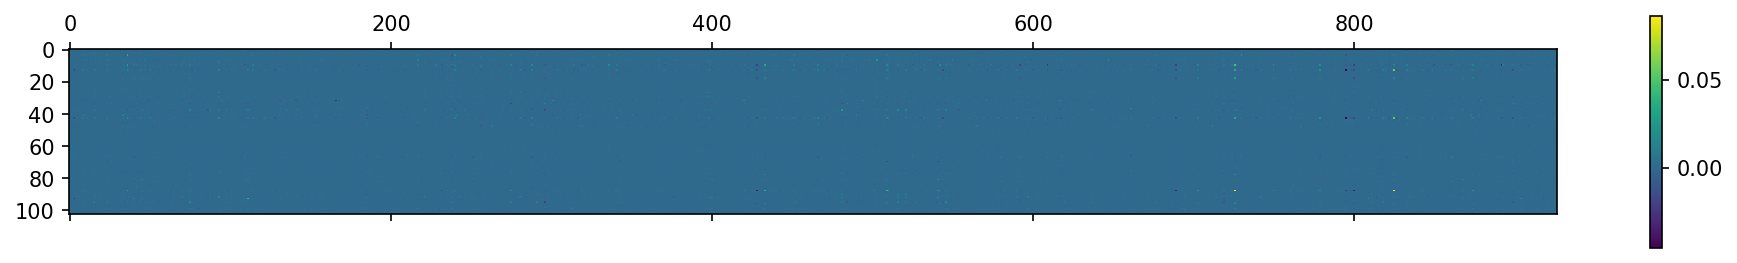

In [23]:
plt.matshow(per_module_scores["6"] / len(train_dataset))
plt.colorbar()

Note that the scores were divided by `len(train_dataset)`, as `compute_pairwise_scores` does not normalize the scores by the total number of training dataset.

## Counterfactual Experiments

How would the model's behaviors on some query data points change if one or more data points were removed from the training dataset? We can use influence functions to identify influential training data points for a randomly selected query dataset.

In [24]:
single_query_dataset = torch.utils.data.Subset(query_dataset, list(range(1)))
len(single_query_dataset)

1

We can compute the averaged loss of this selected query data point over multiple random seeds (e.g., initialization, data ordering).

In [25]:
def train_and_evaluate(modified_train_dataset: data.Dataset, query_dataset: data.Dataset) -> float:
    current_model = train(
        dataset=modified_train_dataset,
        batch_size=train_batch_size,
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        disable_tqdm=True,
    )
    return evaluate(model=current_model, dataset=query_dataset, batch_size=len(query_dataset))

In [26]:
num_iter = 25
base_loss = 0.0
for _ in range(num_iter):
    base_loss += train_and_evaluate(modified_train_dataset=train_dataset, query_dataset=single_query_dataset)
base_loss /= num_iter
base_loss

0.044737880259635855

We repeat the procedure above to identify the top influential training data points for this data point.

In [27]:
analyzer.fit_all_factors(
    factors_name="counterfactual_factors",
    dataset=train_dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)
analyzer.compute_pairwise_scores(
    scores_name="counterfactual_scores",
    factors_name="counterfactual_factors",
    query_dataset=single_query_dataset,
    train_dataset=train_dataset,
    per_device_query_batch_size=len(single_query_dataset),
    overwrite_output_dir=True,
)
scores = analyzer.load_pairwise_scores(scores_name="counterfactual_scores")

Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Performing Eigendecomposition [4/4] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Computing pairwise scores (query gradient) [0

We can visualize the distribution of influence scores.

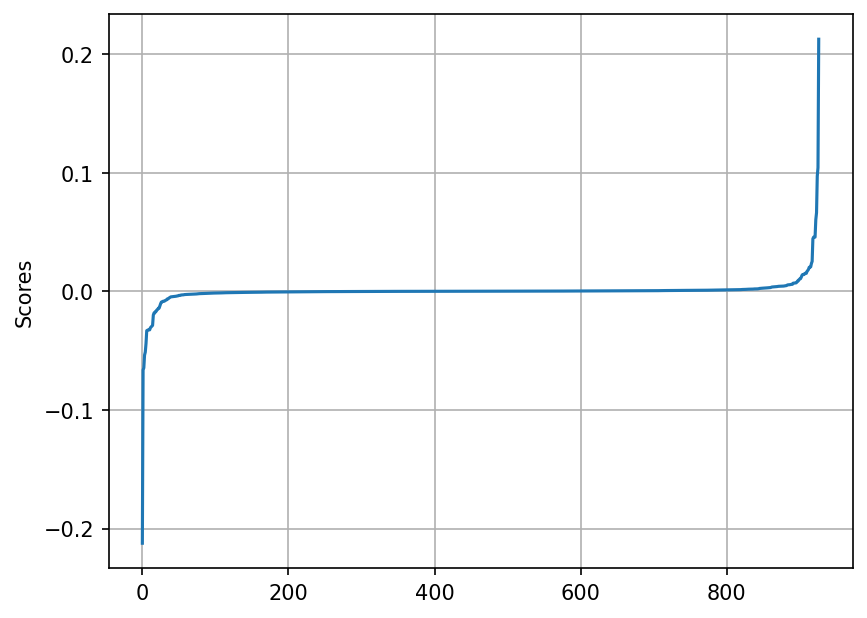

In [28]:
plt.plot(sorted(scores["all_modules"].sum(dim=0) / len(train_dataset)))
plt.ylabel("Scores")
plt.grid()

What happens if we train the model without positively influential data points? Intuitively, the query loss should increase if the model was trained without these top influential data points.

In [29]:
def get_topk_indices(current_score: torch.Tensor, topk: int = 1) -> torch.Tensor:
    return torch.topk(current_score, topk).indices

def get_topk_keep_indices(current_score: torch.Tensor, topk: int = 1) -> List[int]:
    remove_indices = get_topk_indices(current_score, topk)
    remove_indices = [tensor.item() for tensor in remove_indices]
    return list(set(list(range(len(train_dataset)))) - set(remove_indices))

We define `get_topk_keep_indices`, which returns dataset indices with `topk` positively influential data points removed.

In [30]:
len(get_topk_keep_indices(scores["all_modules"].sum(dim=0), topk=10)), len(get_topk_keep_indices(scores["all_modules"].sum(dim=0), topk=20))

(917, 907)

In [ ]:
topk_lst = [5, 10, 15, 20, 25, 30] 
if_removed_loss_lst = []

for topk in topk_lst:
    keep_indices = get_topk_keep_indices(scores["all_modules"].sum(dim=0), topk=topk)
    
    new_loss = 0.
    for _ in range(num_iter):
        new_loss += train_and_evaluate(modified_train_dataset=torch.utils.data.Subset(train_dataset, keep_indices), query_dataset=single_query_dataset)
    new_loss /= num_iter
    if_removed_loss_lst.append(new_loss)

We compare the results with the random baseline, where the same number of data points are removed.

In [ ]:
random_indices = list(range(len(train_dataset)))
shuffle(random_indices)
random_removed_loss_lst = []

for topk in topk_lst:
    keep_indices = random_indices[topk:]
    
    new_loss = 0
    for _ in range(num_iter):
        new_loss += train_and_evaluate(modified_train_dataset=torch.utils.data.Subset(train_dataset, keep_indices), query_dataset=single_query_dataset)
    new_loss /= num_iter
    random_removed_loss_lst.append(new_loss)

In [ ]:
from kronfluence import FactorArguments

factor_args = FactorArguments(strategy="identity")
analyzer.fit_all_factors(
    factors_name="counterfactual_identity_factors",
    dataset=train_dataset,
    factor_args=factor_args,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)
analyzer.compute_pairwise_scores(
    scores_name="counterfactual_identity_scores",
    factors_name="counterfactual_identity_factors",
    query_dataset=single_query_dataset,
    train_dataset=train_dataset,
    per_device_query_batch_size=len(single_query_dataset),
    overwrite_output_dir=True,
)
identity_scores = analyzer.load_pairwise_scores(scores_name="counterfactual_identity_scores")["all_modules"].sum(dim=0)

In [ ]:
id_removed_loss_lst = []

for topk in topk_lst:
    keep_indices = get_topk_keep_indices(identity_scores, topk=topk)
    
    new_loss = 0.
    for _ in range(num_iter):
        new_loss += train_and_evaluate(modified_train_dataset=torch.utils.data.Subset(train_dataset, keep_indices), query_dataset=single_query_dataset)
    new_loss /= num_iter
    id_removed_loss_lst.append(new_loss)

In [ ]:
plt.plot([0] + topk_lst, [base_loss] + random_removed_loss_lst, "o-", label="Random")
plt.plot([0] + topk_lst, [base_loss] + id_removed_loss_lst, "o-", label="TracIn (Identity)")
plt.plot([0] + topk_lst, [base_loss] + if_removed_loss_lst, "o-", label="IF (EKFAC)")
plt.grid()
plt.legend()
plt.ylabel("Query Loss")
plt.xlabel("Number of Training Samples Removed")